In [66]:
import random
import math
import json
import time
import pandas as pd
import numpy as np
import copy as copy
import matplotlib.pyplot as plt
from pandas import Timestamp
from datetime import datetime
from os import getcwd
from os.path import join
%matplotlib inline


In [67]:
# Load World Mortality Data
path = join(getcwd().rstrip('src'),
            'data/world_mortality.csv').replace('\\', '/')
DF = pd.read_csv(path)
DF.rename(columns={'country_name': 'country'}, inplace=True)

# Separate Data by Year
DF_Regular = DF[DF.year < 2020]
DF_2020 = DF[(DF.year == 2020)]
DF_2021 = DF[(DF.year == 2021)]
DF_2022 = DF[(DF.year == 2022)]

# Data for 2015-2019
Regular = DF_Regular.groupby('country').mean().reset_index()
Regular['AverageAnnualUnitCount'] = round(Regular.time * 2 - 1, 0)
tmp = copy.copy(DF)
time_unit_dict = {'monthly': 12, 'weekly': 52}
tmp['AnnualUnitCount'] = [time_unit_dict[x] for x in tmp.time_unit]
tmp = tmp.groupby('country').mean().reset_index()[
    ['country', 'AnnualUnitCount']]
Regular = pd.merge(Regular, tmp, on='country')
Regular['deaths'] = Regular.deaths * Regular.AnnualUnitCount
Regular = Regular[['country', 'deaths', 'AverageAnnualUnitCount']]

# Data for 2020
DF_2020 = DF_2020.groupby('country').mean().reset_index()
DF_2020['AverageAnnualUnitCount'] = round(DF_2020.time * 2 - 1, 0)
DF_2020 = pd.merge(DF_2020, tmp, on='country')
DF_2020['deaths'] = DF_2020.deaths * DF_2020.AnnualUnitCount
DF_2020 = DF_2020[['country', 'deaths', 'AverageAnnualUnitCount']]

# Data for 2021
DF_2021 = DF_2021.groupby('country').mean().reset_index()
DF_2021['AverageAnnualUnitCount'] = round(DF_2021.time * 2 - 1, 0)
DF_2021 = pd.merge(DF_2021, tmp, on='country')
DF_2021['deaths'] = DF_2021.deaths * DF_2021.AnnualUnitCount
DF_2021 = DF_2021[['country', 'deaths', 'AverageAnnualUnitCount']]

# Data for 2022
DF_2022 = DF_2022.groupby('country').mean().reset_index()
DF_2022['AverageAnnualUnitCount'] = round(DF_2022.time * 2 - 1, 0)
DF_2022 = pd.merge(DF_2022, tmp, on='country')
DF_2022['deaths'] = DF_2022.deaths * DF_2022.AnnualUnitCount
DF_2022 = DF_2022[['country', 'deaths', 'AverageAnnualUnitCount']]

# Merge Data (2015-2019, 2020, 2021, 2022)
newDF = pd.concat([Regular, DF_2020[['deaths']],
                  DF_2021[['deaths']], DF_2022[['deaths']]], axis=1)
newDF.columns = ['country', 'RegularDeaths',
                 'RegularAverageAnnualUnitCount', '2020Deaths', '2021Deaths', '2022Deaths']
newDF = newDF.reindex(['country', 'RegularAverageAnnualUnitCount', 'RegularDeaths',
                       '2020Deaths', '2021Deaths', '2022Deaths'], axis='columns')

# Excess Deaths (2020, 2021, 2022)
EXD2020 = newDF['2020Deaths'] - newDF['RegularDeaths']
EXD2020.rename('EXD2020', inplace=True)
EXD2021 = newDF['2021Deaths'] - newDF['RegularDeaths']
EXD2021.rename('EXD2021', inplace=True)
EXD2022 = newDF['2022Deaths'] - newDF['RegularDeaths']
EXD2022.rename('EXD2022', inplace=True)
newDF = pd.concat([newDF, EXD2020, EXD2021, EXD2022], axis=1)
newDF.rename(columns={'RegularAverageAnnualUnitCount': 'RAAUC'}, inplace=True)

# Merge with OWID Population Data
path = join(getcwd().rstrip('src'),
            'data/owid-covid-data.csv').replace('\\', '/')
data = pd.read_csv(path)
data = data[['location', 'population']]
data.rename(columns={'location': 'country'}, inplace=True)
data.groupby('country').count().sort_values(by='population', ascending=False)
data.drop_duplicates(subset=['country'], inplace=True)
data.reset_index(drop=True, inplace=True)
con1 = list(data.country)
con2 = list(newDF.country)
pop = []
for c in con2:
    if c in con1:
        pop.append(data[data.country == c].population.values[0])
    else:
        pop.append(0)
pop = pd.Series(pop, name='population')
newDF = pd.concat([newDF['country'], newDF['RAAUC'], pop, newDF['RegularDeaths'], newDF['2020Deaths'],
                  newDF['2021Deaths'], newDF['2022Deaths'], newDF['EXD2020'], newDF['EXD2021'], newDF['EXD2022']], axis=1)

# Excess Deaths per Million (2020, 2021, 2022)
RDPP = newDF['RegularDeaths'] / newDF['population'] * 1000000
RDPP.rename('RDBP', inplace=True)  # Regular Deaths by Population Percentage
IDPP2020 = newDF['2020Deaths'] / newDF['population'] * 1000000
# Irregular Deaths by Population in Percentage in 2020
IDPP2020.rename('IDPP2020', inplace=True)
IDPP2021 = newDF['2021Deaths'] / newDF['population'] * 1000000
# Irregular Deaths by Population in Percentage in 2021
IDPP2021.rename('IDPP2021', inplace=True)
IDPP2022 = newDF['2022Deaths'] / newDF['population'] * 1000000
# Irregular Deaths by Population in Percentage in 2022
IDPP2022.rename('IDPP2022', inplace=True)
EDPP2020 = newDF['EXD2020'] / newDF['population'] * 1000000
# Excess Deaths by Population in Percentage in 2020
EDPP2020.rename('EDPP2020', inplace=True)
EDPP2021 = newDF['EXD2021'] / newDF['population'] * 1000000
# Excess Deaths by Population in Percentage in 2021
EDPP2021.rename('EDPP2021', inplace=True)
EDPP2022 = newDF['EXD2022'] / newDF['population'] * 1000000
# Excess Deaths by Population in Percentage in 2022
EDPP2022.rename('EDPP2022', inplace=True)
newDF = pd.concat([newDF, RDPP, IDPP2020, IDPP2021,
                  IDPP2022, EDPP2020, EDPP2021, EDPP2022], axis=1)

# Export Data
newDF.to_csv(join(getcwd().rstrip('src'),
                  'data/bd_w13_hw/table.csv').replace('\\', '/'), sep=';', index=False)

# Show Data
newDF.head()


,country,RAAUC,population,RegularDeaths,2020Deaths,2021Deaths,2022Deaths,EXD2020,EXD2021,EXD2022,RDBP,IDPP2020,IDPP2021,IDPP2022,EDPP2020,EDPP2021,EDPP2022
0,Albania,12.0,2854710.0,21955.80,27605.0,30580.0,25708.000000,5649.20,8624.20,3752.200000,7691.078954,9669.983991,10712.121371,9.005468e+03,1978.905038,3021.042418,1.314389e+03
1,Algeria,12.0,44177969.0,179289.65,235628.0,649.0,27462.666667,56338.35,-178640.65,-151826.983333,4058.349763,5333.608704,14.690580,6.216371e+02,1275.258942,-4043.659182,-3.436713e+03
2,Andorra,12.0,79034.0,310.20,419.0,34638.0,190732.533333,108.80,34327.80,190422.333333,3924.893084,5301.515803,438267.074930,2.413297e+06,1376.622719,434342.181846,2.409372e+06
3,Antigua and Barbuda,12.0,93220.0,570.60,574.0,964.0,89276.571429,3.40,393.40,88705.971429,6121.004076,6157.476936,10341.128513,9.576976e+05,36.472860,4220.124437,9.515766e+05
4,Argentina,12.0,45276780.0,341388.60,376221.0,170960.0,62637.000000,34832.40,-170428.60,-278751.600000,7540.037079,8309.358572,3775.886889,1.383424e+03,769.321493,-3764.150189,-6.156613e+03


# HW

Using the same data from the previous homework, create a graph similar to the one shown below.

X: Total COVID-19 deaths in 2020 and 2021 per million people.==========>$X=(\text{2020 deaths}) + (\text{2021 deaths})$<br>
Y: Ratio of the projected deaths in 2022 and total deaths in 2020 and 2021.==>$Y=\cfrac{(\text{2022 deaths})}{(\text{X})}$

## Get X and Y

In [68]:
X = (newDF['2020Deaths'] + newDF['2021Deaths']) / newDF['population'] * (10 ** 6)
Y = (newDF['2022Deaths'] / newDF['population'] * (10 ** 6)) / newDF['population']
X.rename('X', inplace=True)
Y.rename('Y', inplace=True)
newDF = pd.concat([newDF, X, Y], axis=1)

# Export Data
newDF.to_csv(join(getcwd().rstrip('src'),
                  'data/bd_w13_hw/tableXY.csv').replace('\\', '/'), sep=';', index=False)

newDF.head()

,country,RAAUC,population,RegularDeaths,2020Deaths,2021Deaths,2022Deaths,EXD2020,EXD2021,EXD2022,RDBP,IDPP2020,IDPP2021,IDPP2022,EDPP2020,EDPP2021,EDPP2022,X,Y
0,Albania,12.0,2854710.0,21955.80,27605.0,30580.0,25708.000000,5649.20,8624.20,3752.200000,7691.078954,9669.983991,10712.121371,9.005468e+03,1978.905038,3021.042418,1.314389e+03,20382.105363,0.003155
1,Algeria,12.0,44177969.0,179289.65,235628.0,649.0,27462.666667,56338.35,-178640.65,-151826.983333,4058.349763,5333.608704,14.690580,6.216371e+02,1275.258942,-4043.659182,-3.436713e+03,5348.299285,0.000014
2,Andorra,12.0,79034.0,310.20,419.0,34638.0,190732.533333,108.80,34327.80,190422.333333,3924.893084,5301.515803,438267.074930,2.413297e+06,1376.622719,434342.181846,2.409372e+06,443568.590733,30.534925
3,Antigua and Barbuda,12.0,93220.0,570.60,574.0,964.0,89276.571429,3.40,393.40,88705.971429,6121.004076,6157.476936,10341.128513,9.576976e+05,36.472860,4220.124437,9.515766e+05,16498.605449,10.273521
4,Argentina,12.0,45276780.0,341388.60,376221.0,170960.0,62637.000000,34832.40,-170428.60,-278751.600000,7540.037079,8309.358572,3775.886889,1.383424e+03,769.321493,-3764.150189,-6.156613e+03,12085.245461,0.000031


## Plot X and Y

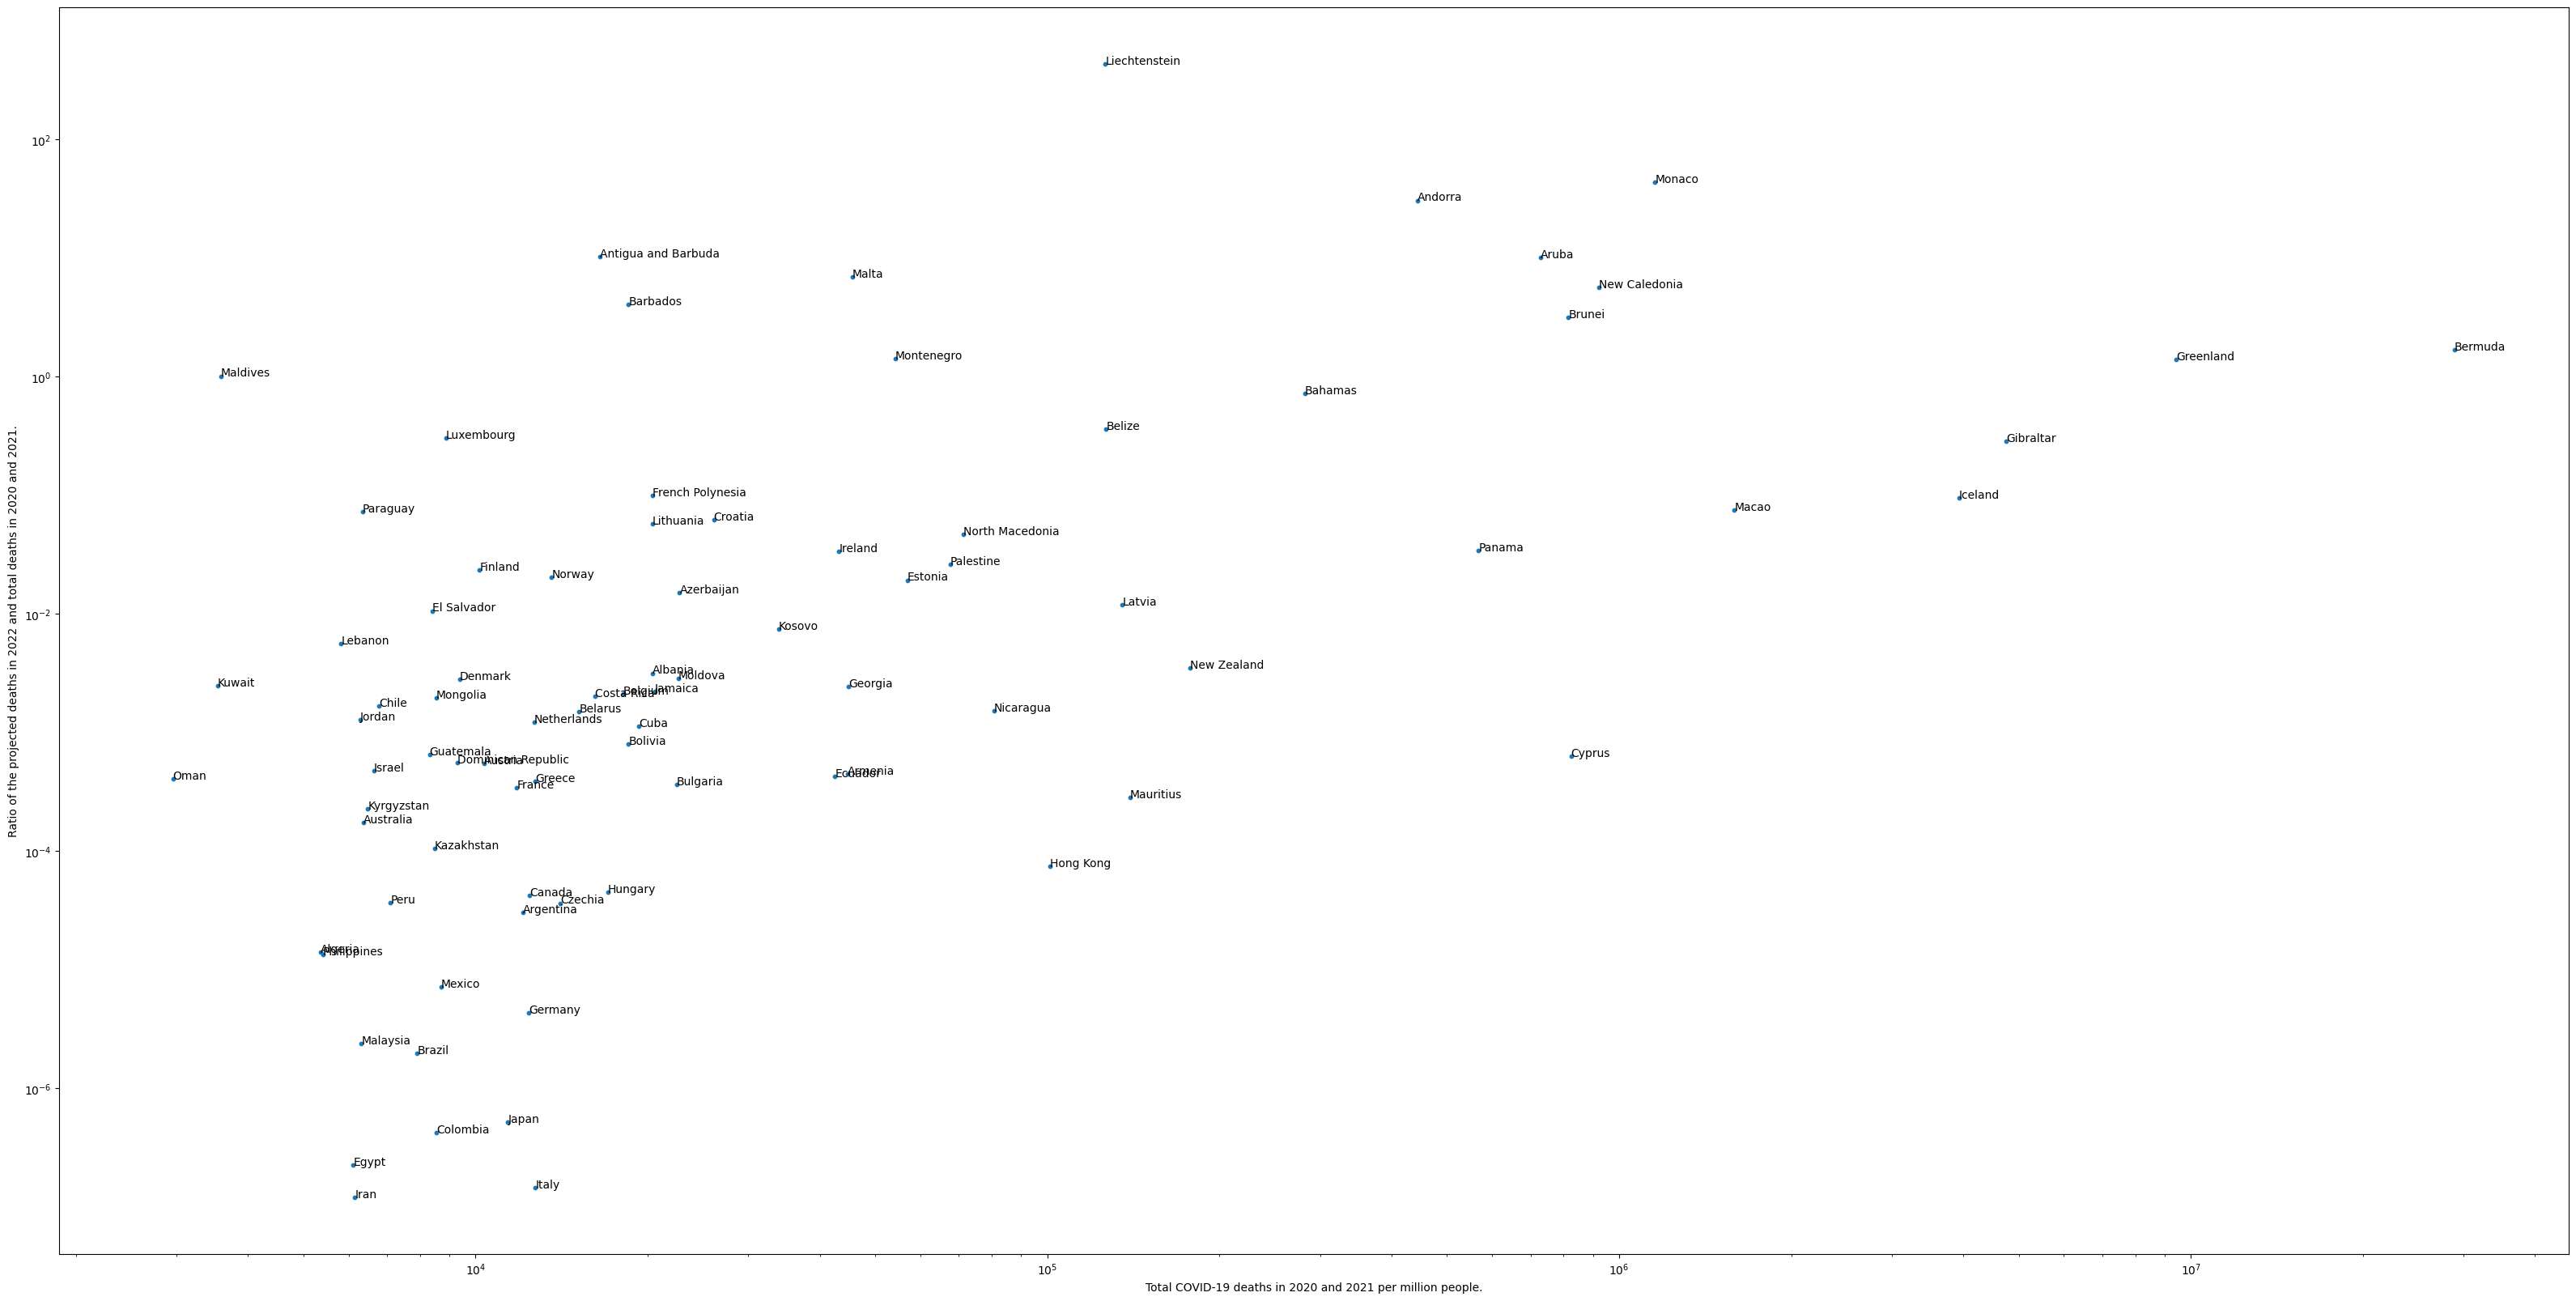

In [94]:
fig = plt.figure(figsize=(40, 20), dpi=100)
ax = fig.add_subplot()
plt.xlabel('Total COVID-19 deaths in 2020 and 2021 per million people.')
plt.ylabel(
    'Ratio of the projected deaths in 2022 and total deaths in 2020 and 2021.')
plt.scatter(x=newDF['X'], y=newDF['Y'], s=10)
plt.xscale('log')
plt.yscale('log')

for index, row in newDF.iterrows():
    # plt.annotate(row['country'], (float(row['X']), float(row['Y'])))
    if math.isinf(row['X']) or math.isinf(row['Y']) or math.isnan(row['X']) or math.isnan(row['Y']):
        pass
    else:
        # if row['country'] == 'Algeria':
        #     rotation = 'vertical'
        # else:
        #     x = row['X']
        #     y = row['Y']
        #     rotation = 'horizontal'
        # print(row['country'], x, y, rotation)
        x = row['X']
        y = row['Y']
        rotation = 'horizontal'
        ax.text(x=x, y=y, s=row['country'], rotation=rotation, horizontalalignment='left', fontsize=10)

plt.show()
